In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/debug_ipllr_2')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.data.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.debug_ipllr import *

### Load basic configuration and define variables 

In [5]:
N_TRIALS = 5
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 128
base_lr = 0.01
n_steps = 50

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [6]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define models

In [7]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [8]:
ipllrs = [FcIPLLR(base_model_config, n_warmup_steps=12, lr_calibration_batches=batches) for _ in range(N_TRIALS)]
base_model_config.scheduler = None
muPs = [FCmuP(base_model_config) for _ in range(N_TRIALS)]

initial base lr : [0.06567156314849854, 0.04262147098779678, 0.8678671717643738, 1.53627347946167, 1.5419093370437622, 1.4907394647598267, 3.480341911315918]
initial base lr : [0.06547180563211441, 0.0425226055085659, 0.8864796757698059, 1.55824875831604, 1.571073055267334, 1.6020781993865967, 4.033243656158447]
initial base lr : [0.06283728033304214, 0.04251725226640701, 0.8891249895095825, 1.7453489303588867, 1.7088663578033447, 1.5428811311721802, 3.5358574390411377]
initial base lr : [0.06454648077487946, 0.04258213937282562, 0.9129555225372314, 1.6816322803497314, 1.7853425741195679, 1.6879618167877197, 3.7981910705566406]
initial base lr : [0.06329051405191422, 0.04407721012830734, 0.7832615375518799, 1.3711072206497192, 1.220157504081726, 1.188452959060669, 2.999570369720459]


In [10]:
for ipllr in ipllrs:
    ipllr.scheduler.calibrate_base_lr(muP, batches=batches)

initial base lr : [0.052250687032938004, 0.033954374492168427, 0.026727819815278053, 0.02120259776711464, 0.01873043179512024, 0.018592122942209244, 0.03491514176130295]
initial base lr : [0.052250687032938004, 0.033954374492168427, 0.026727819815278053, 0.02120259776711464, 0.01873043179512024, 0.018592122942209244, 0.03491514176130295]
initial base lr : [0.052250687032938004, 0.033954374492168427, 0.026727819815278053, 0.02120259776711464, 0.01873043179512024, 0.018592122942209244, 0.03491514176130295]
initial base lr : [0.052250687032938004, 0.033954374492168427, 0.026727819815278053, 0.02120259776711464, 0.01873043179512024, 0.018592122942209244, 0.03491514176130295]
initial base lr : [0.052250687032938004, 0.033954374492168427, 0.026727819815278053, 0.02120259776711464, 0.01873043179512024, 0.018592122942209244, 0.03491514176130295]


In [11]:
for i, ipllr in enumerate(ipllrs):
    ipllr.copy_initial_params_from_model(muPs[i])
    ipllr.initialize_params()

In [12]:
muPs_0 = [deepcopy(muP) for muP in muPs]

x, y = batches[0]
for muP in muPs:
    train_model_one_step(ipllr, x, y, batch_size)

input abs mean in training:  0.7020161151885986
loss derivatives for model: tensor([[-0.9000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        ...,
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000]])
average training loss for model1 : 2.3025827407836914

input abs mean in training:  0.7020161151885986
loss derivatives for model: tensor([[-0.9450,  0.0652,  0.0885,  ...,  0.0646,  0.4141,  0.0709],
        [ 0.0482, -0.9416,  0.0825,  ...,  0.0578,  0.4708,  0.0642],
        [ 0.0617,  0.0716,  0.0935,  ...,  0.0710,  0.3605, -0.9229],
        ...,
        [ 0.0353,  0.0448,  0.0685,  ...,  0.0442, -0.4144,  0.0503],
        [ 0.0599,  0.0699,  0.0923,  ...,  0.0693, -0.6256,  0.075

In [13]:
x, y = batches[0]
ipllrs_1 = []
for ipllr in ipllrs:
    train_model_one_step(ipllr, x, y, batch_size)
    ipllrs_1.append(deepcopy(ipllr))

input abs mean in training:  0.7020161151885986
loss derivatives for model: tensor([[-0.9000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        ...,
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000]])
average training loss for model1 : 2.3025827407836914

input abs mean in training:  0.7020161151885986
loss derivatives for model: tensor([[-0.9000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        ...,
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.100

In [14]:
results = {'muP': [], 'IPLLR': []}
results['muP'] = [collect_scales(muPs[i], muPs_0[i], batches[1:], eval_batch, n_steps) 
                  for i in range(N_TRIALS)]

In [15]:
results['IPLLR'] = [collect_scales(ipllrs[i], ipllrs_1[i], batches[1:], eval_batch, n_steps) 
                    for i in range(N_TRIALS)]

# Training

In [16]:
mode = 'training'

In [17]:
losses_muP = [r[0] for r in results['muP']]
losses_ip = [r[0] for r in results['IPLLR']]

chis_muP = [r[1] for r in results['muP']]
chis_ip = [r[1] for r in results['IPLLR']]

## Losses and derivatives

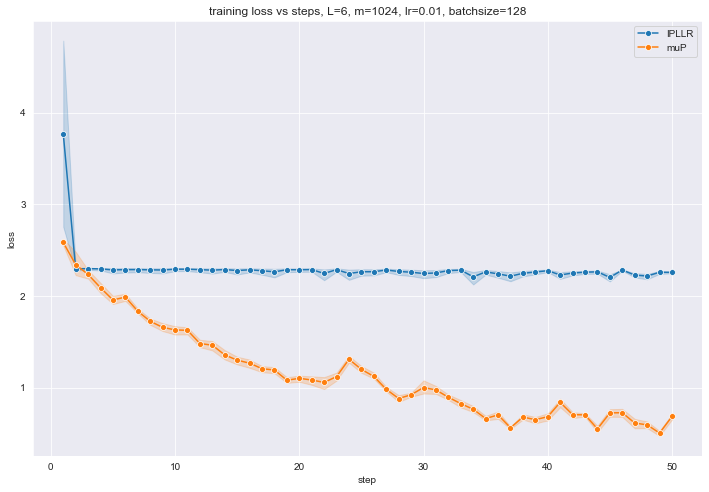

In [18]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses(losses_ip, losses_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

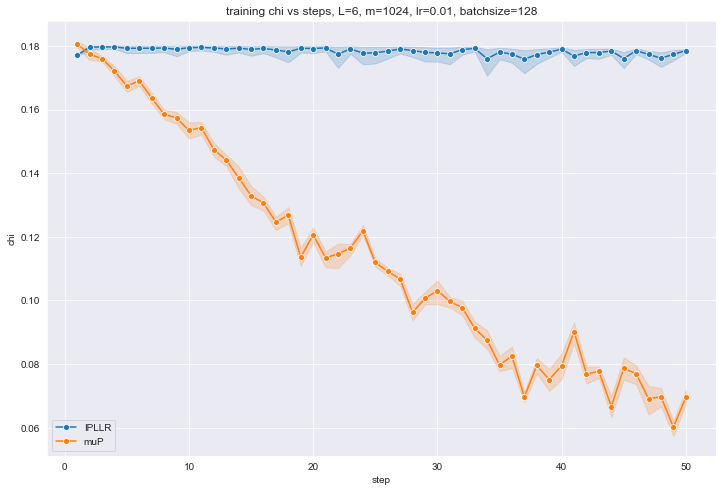

In [19]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses(chis_ip, chis_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

### Magnitude of the actvations of the network at different layers

In [20]:
dfs_muP = [r[2] for r in results['muP']]
dfs_ip = [r[2] for r in results['IPLLR']]

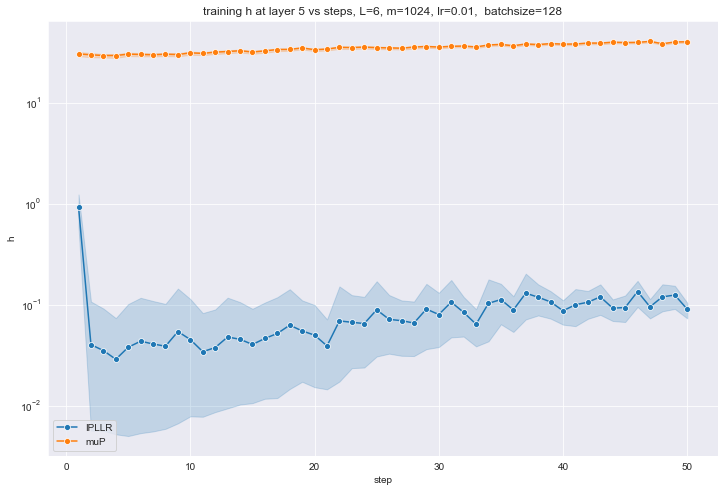

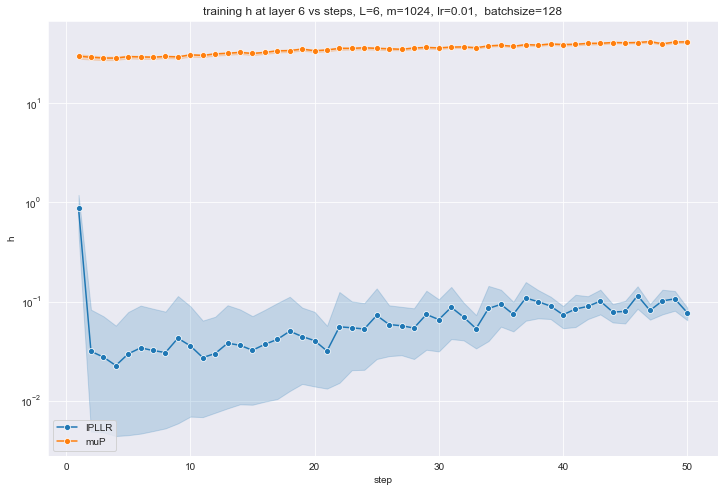

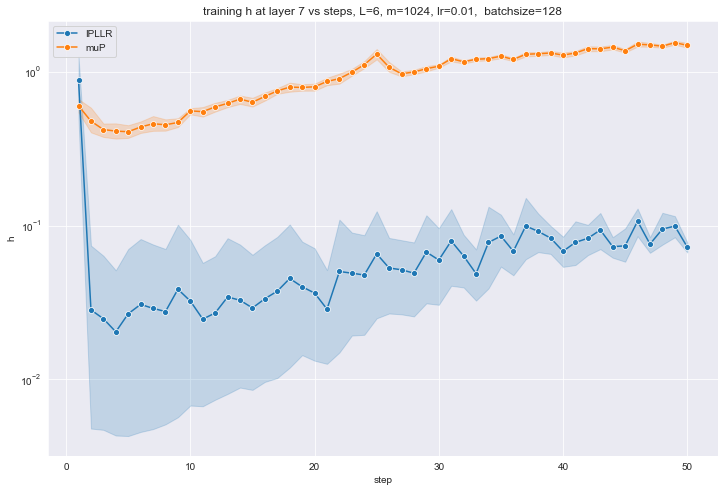

In [21]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                               batch_size)))
    plt.show()

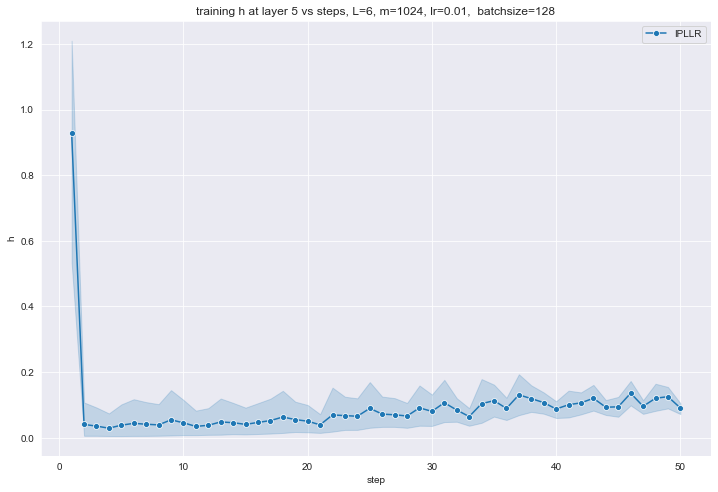

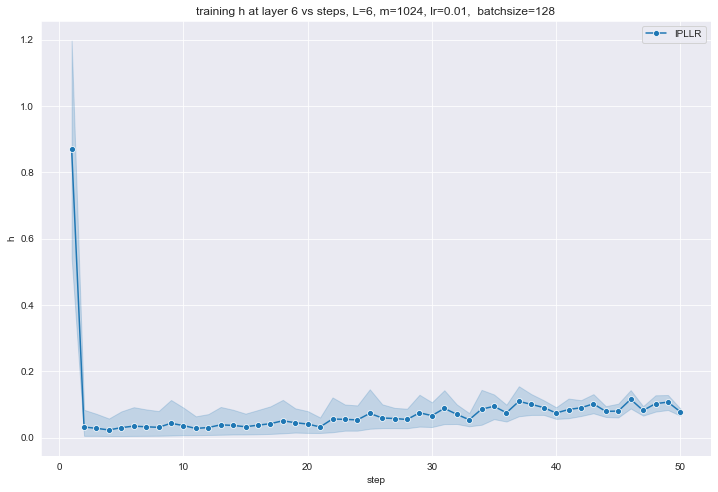

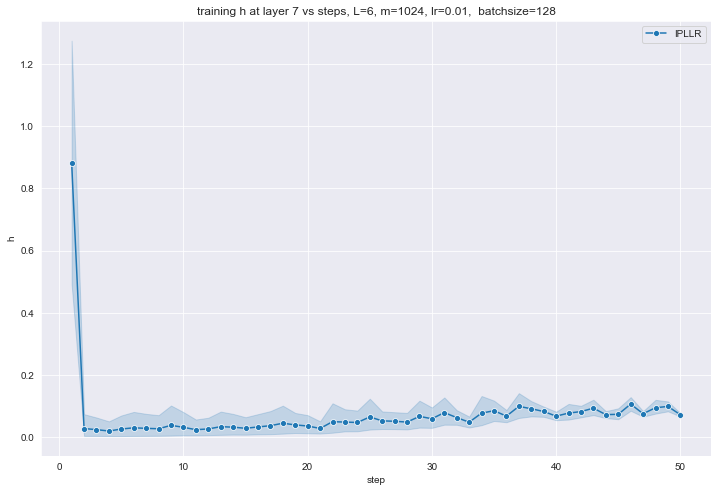

In [22]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, None, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_ip_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                                  batch_size)))
    plt.show()

### Contribution of the init to the activations at different layers.

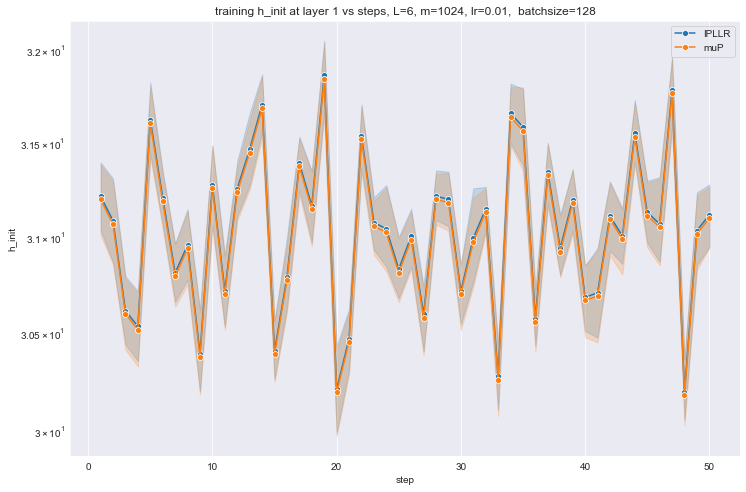

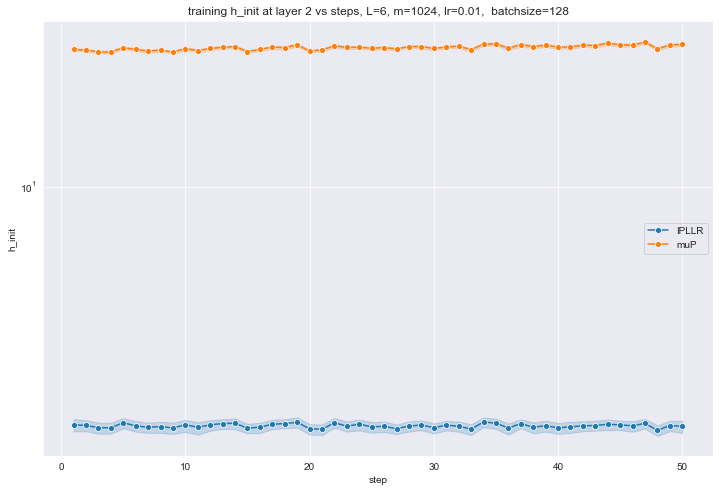

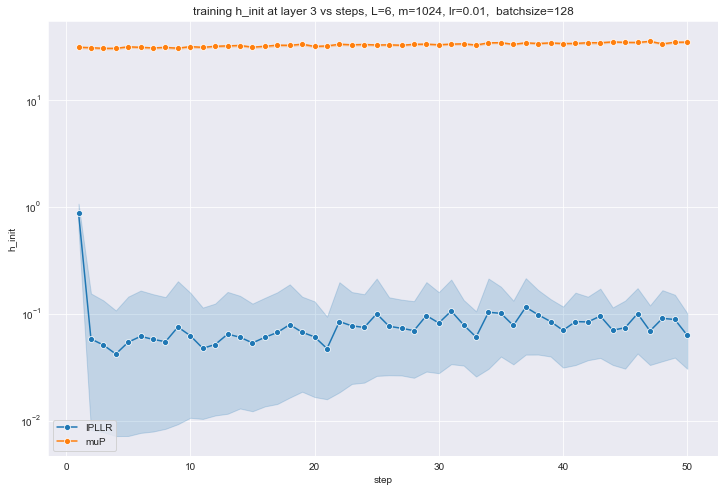

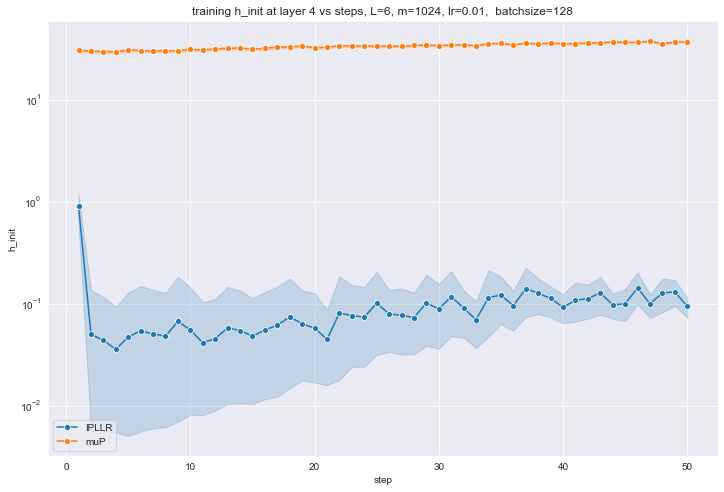

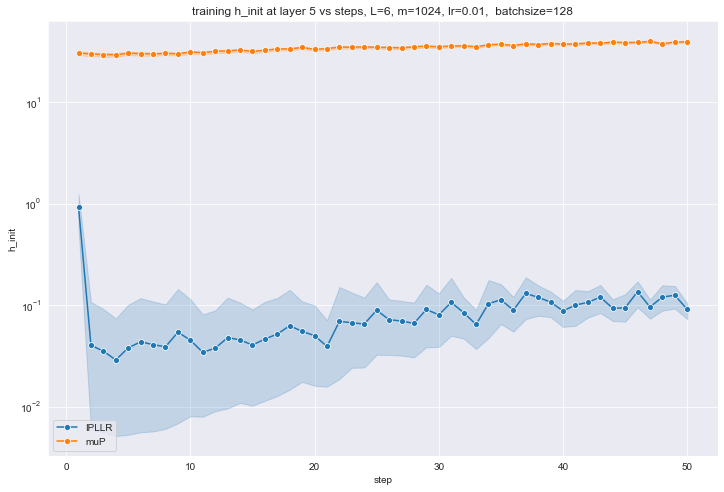

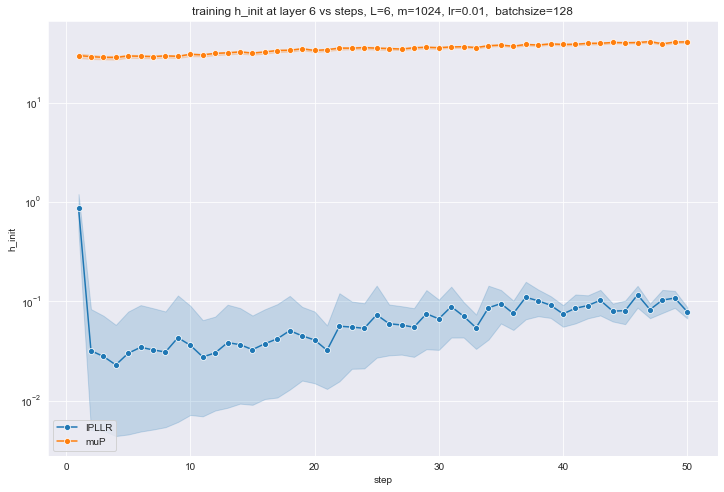

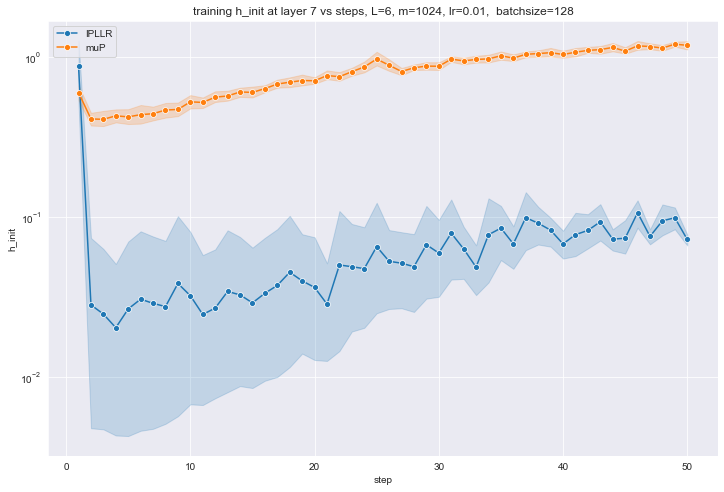

In [23]:
key = 'h_init'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

### Magnitude of the update at different layers.

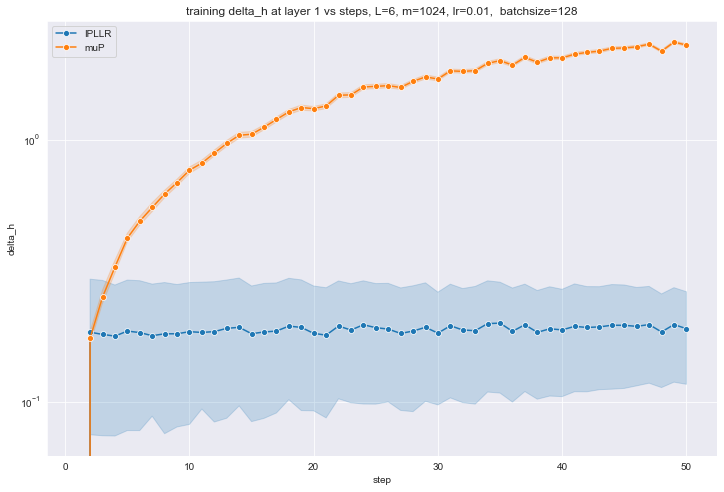

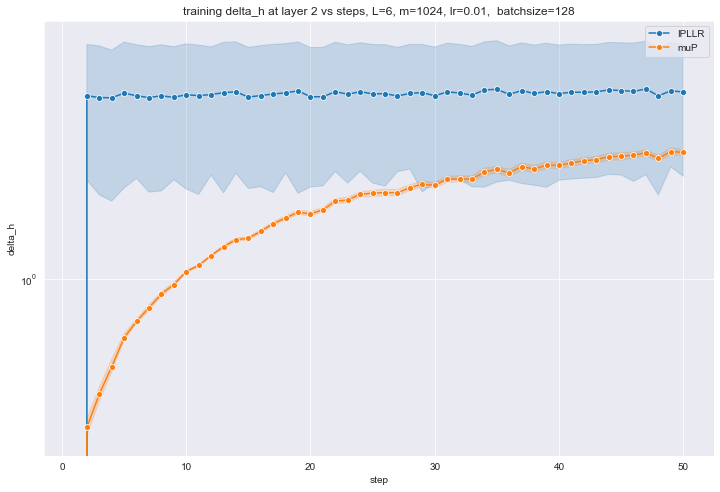

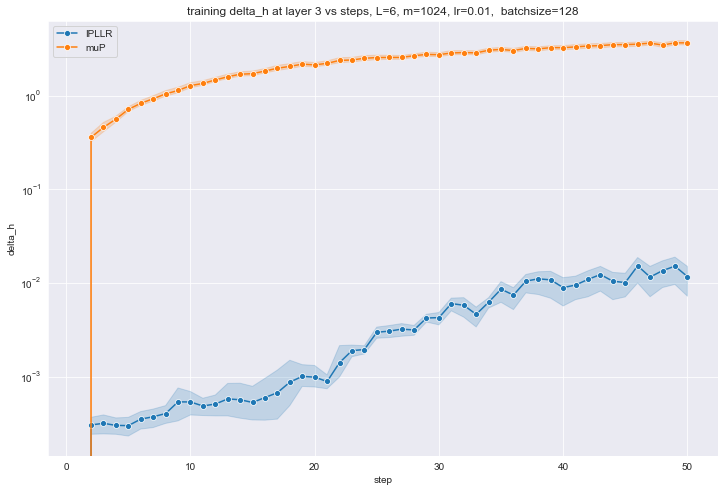

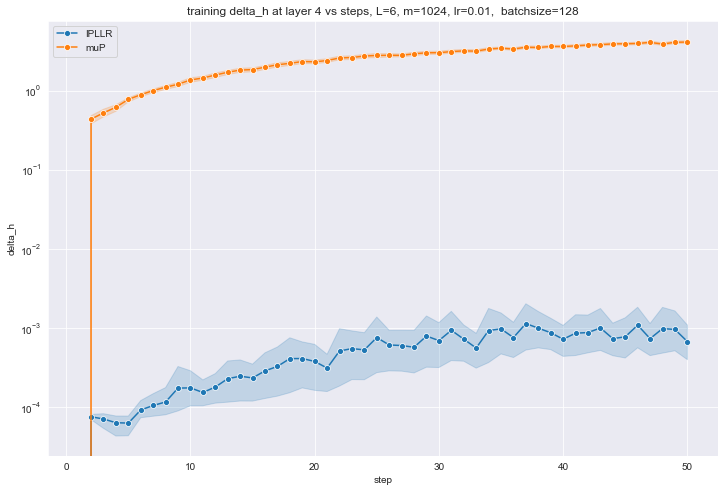

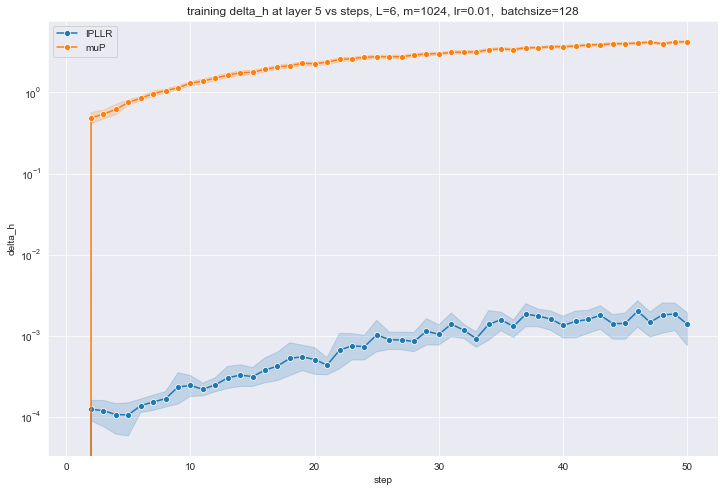

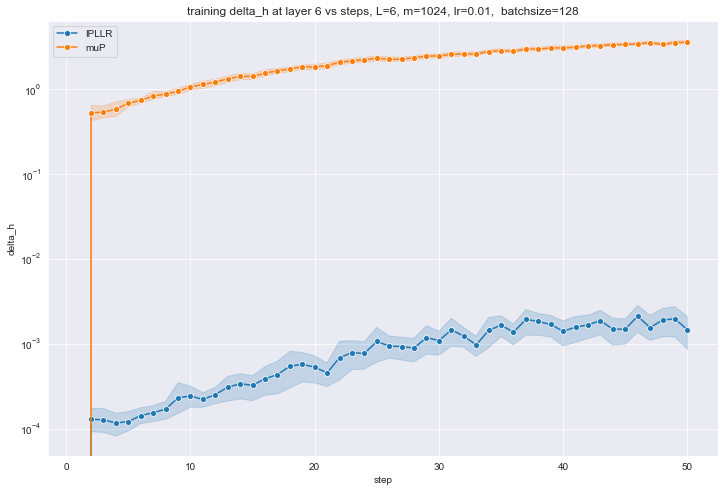

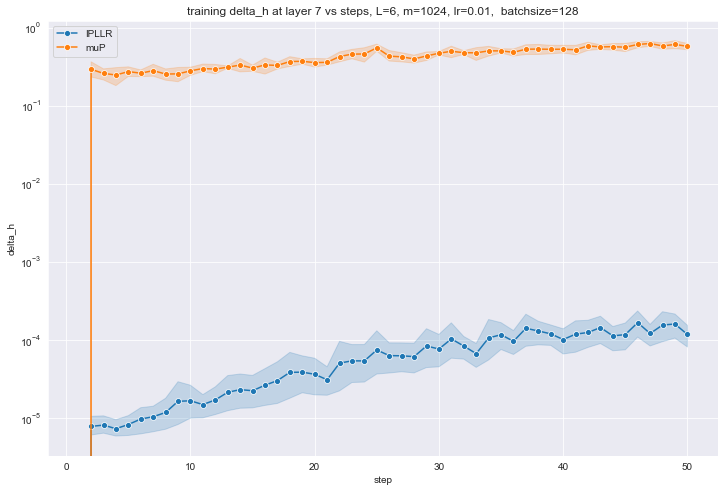

In [24]:
key = 'delta_h'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

# Validation

In [25]:
mode = 'val'

In [26]:
dfs_muP = [r[3] for r in results['muP']]
dfs_ip = [r[3] for r in results['IPLLR']]

## Losses and derivatives

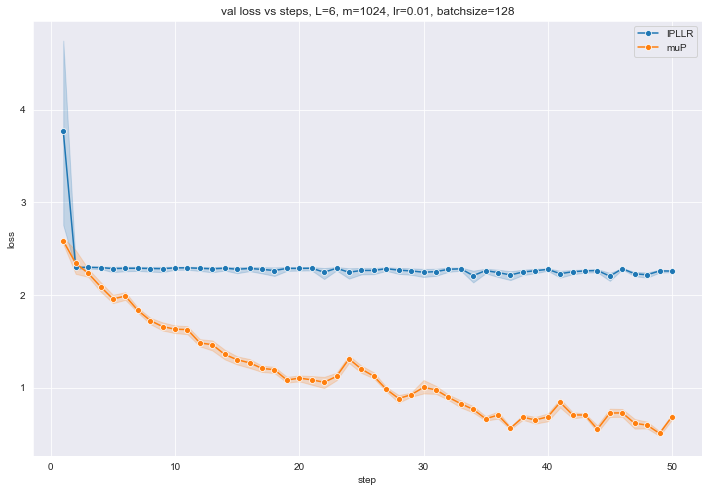

In [27]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses(losses_ip, losses_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

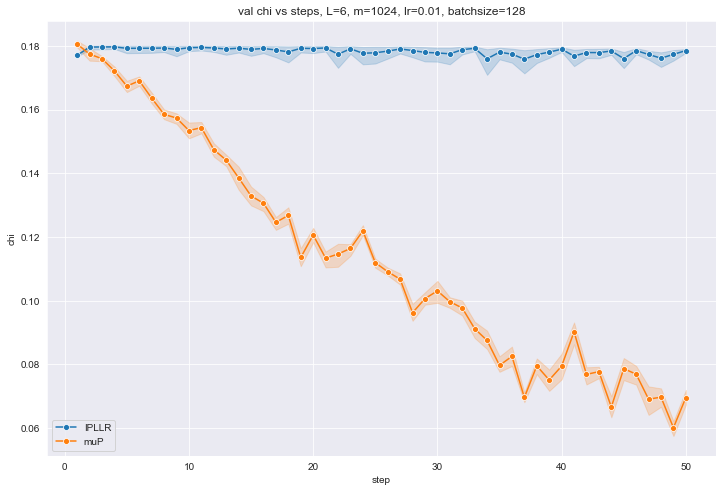

In [28]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses(chis_ip, chis_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

### Magnitude of the actvations of the network at different layers

In [29]:
dfs_muP = [r[2] for r in results['muP']]
dfs_ip = [r[2] for r in results['IPLLR']]

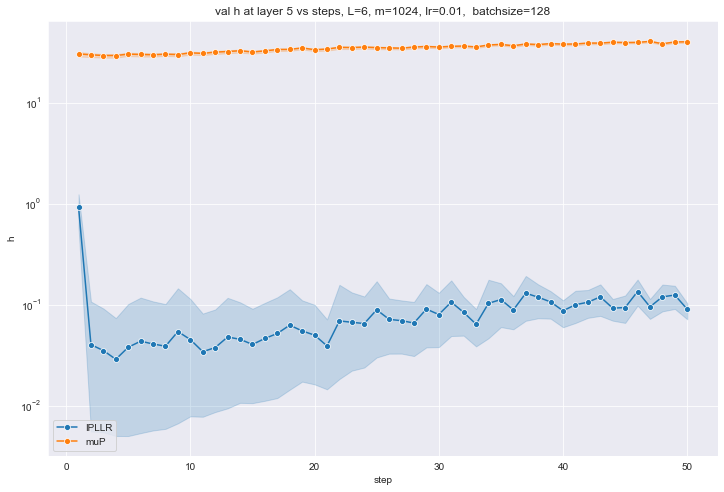

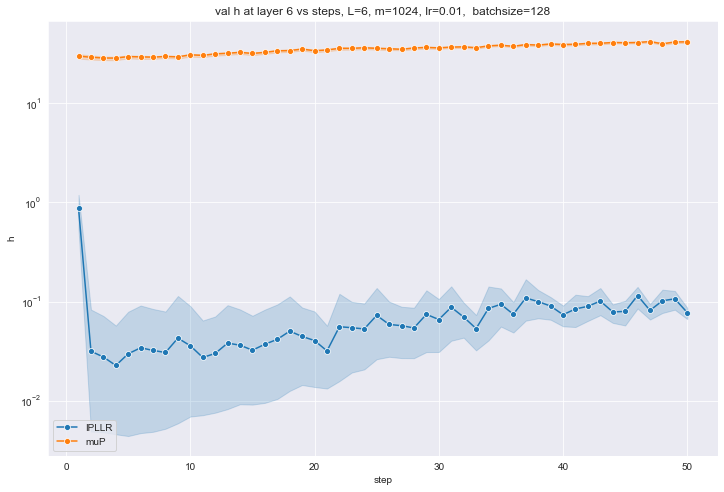

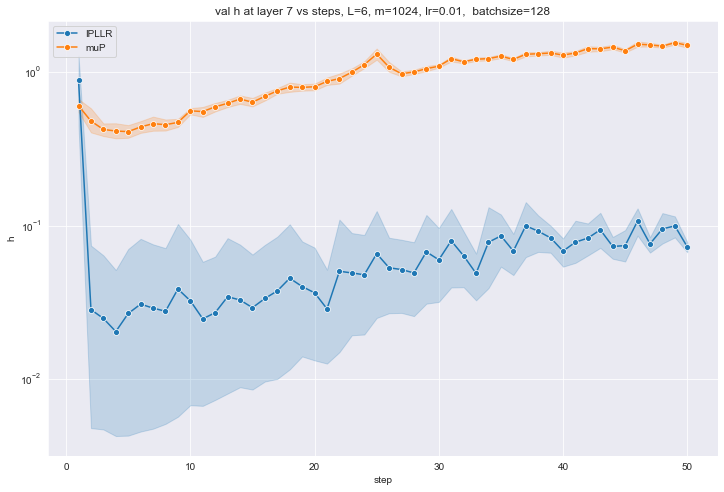

In [30]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                               batch_size)))
    plt.show()

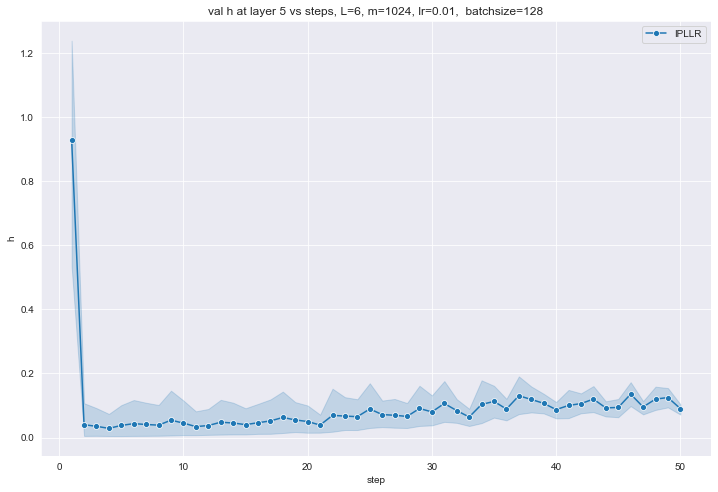

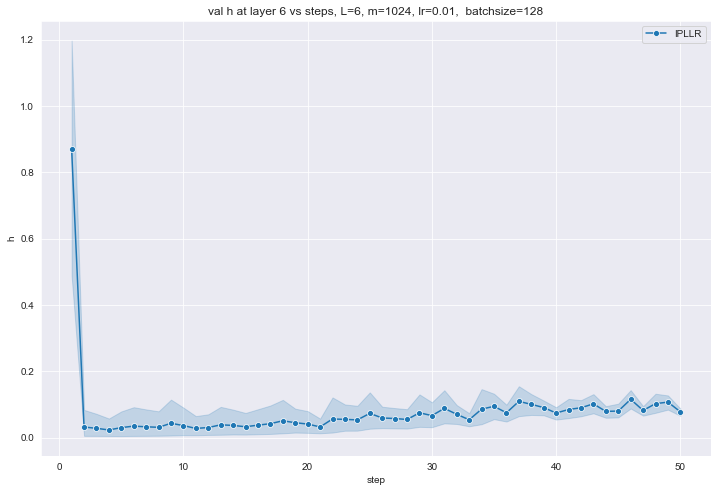

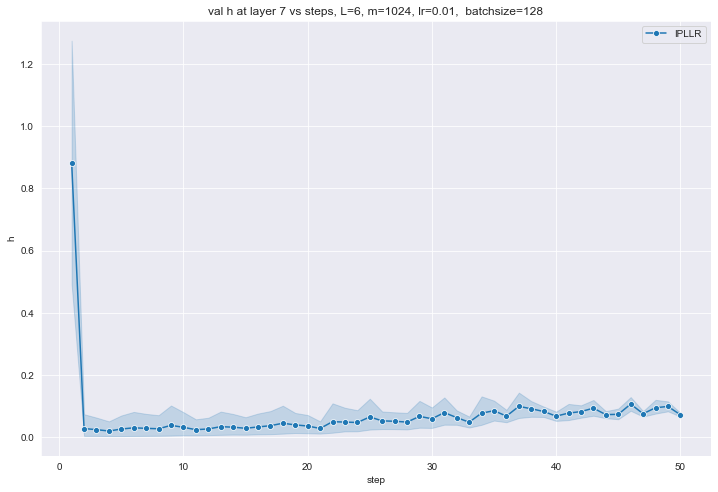

In [31]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, None, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_ip_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                                  batch_size)))
    plt.show()

### Contribution of the init to the activations at different layers.

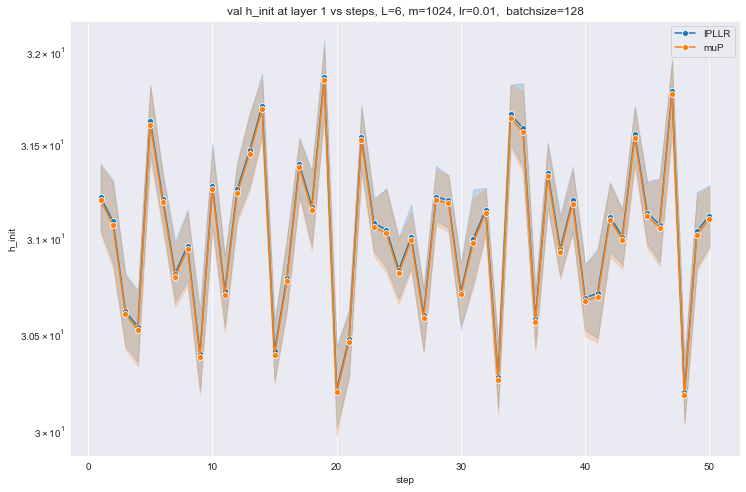

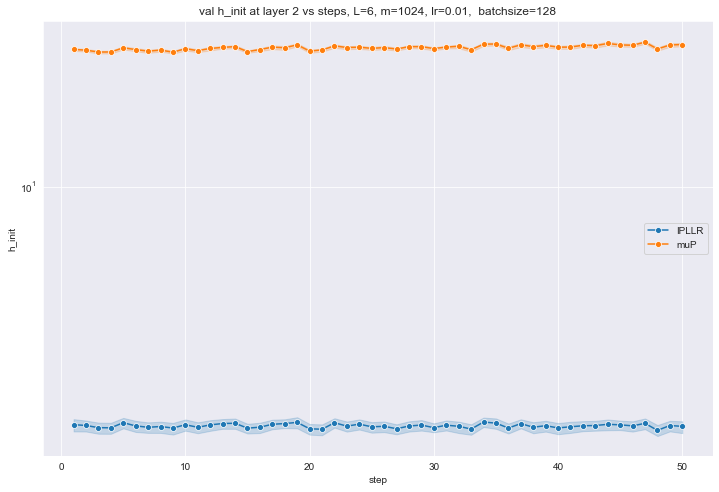

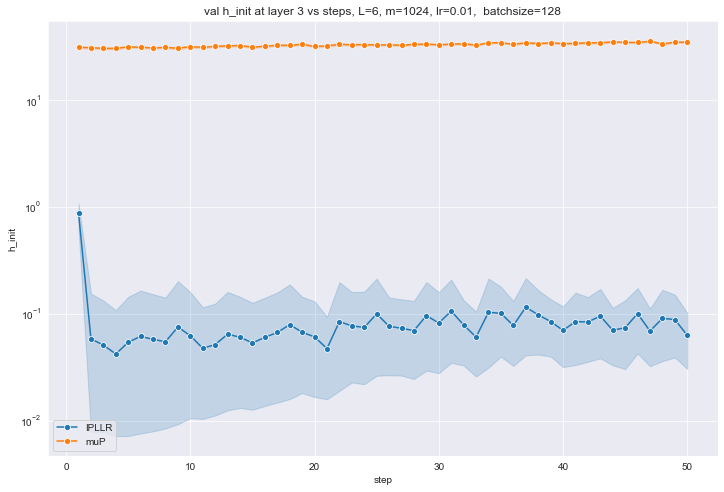

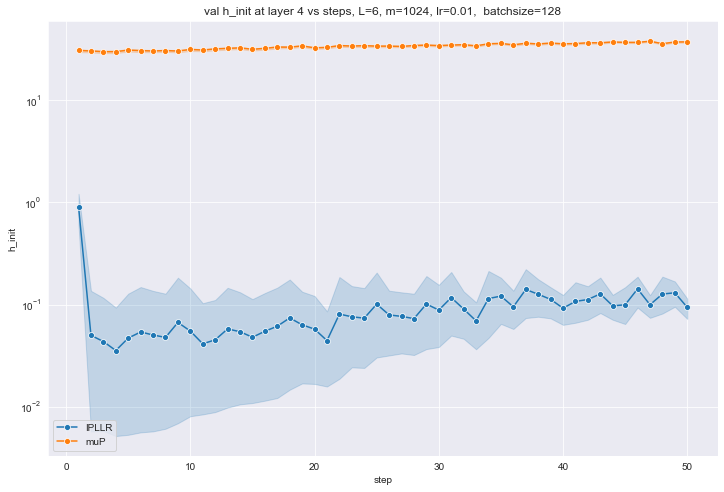

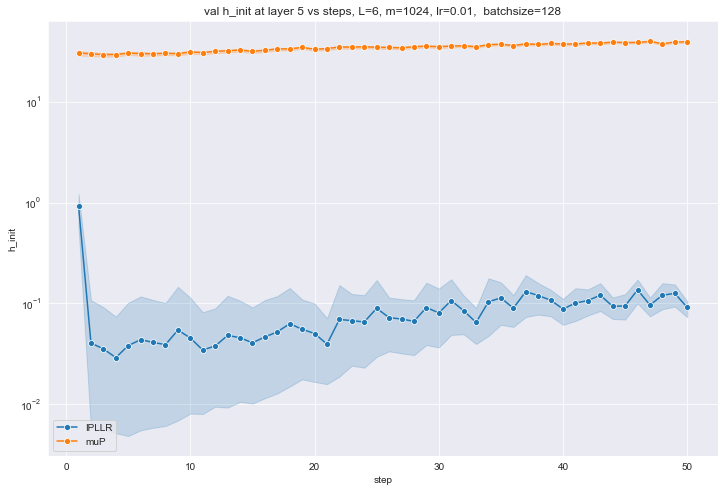

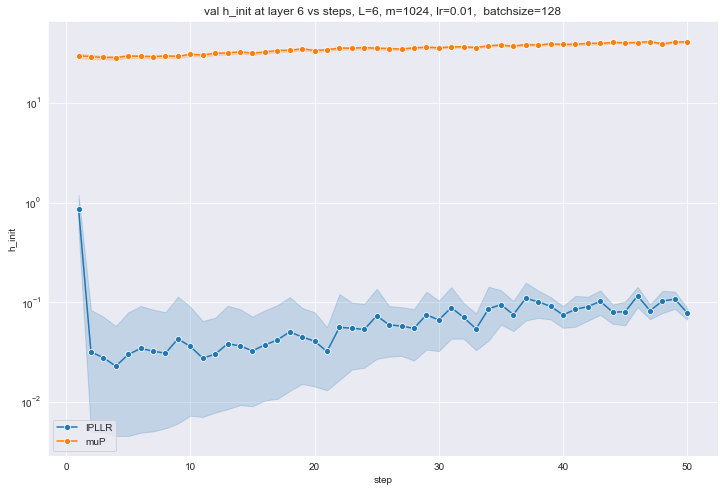

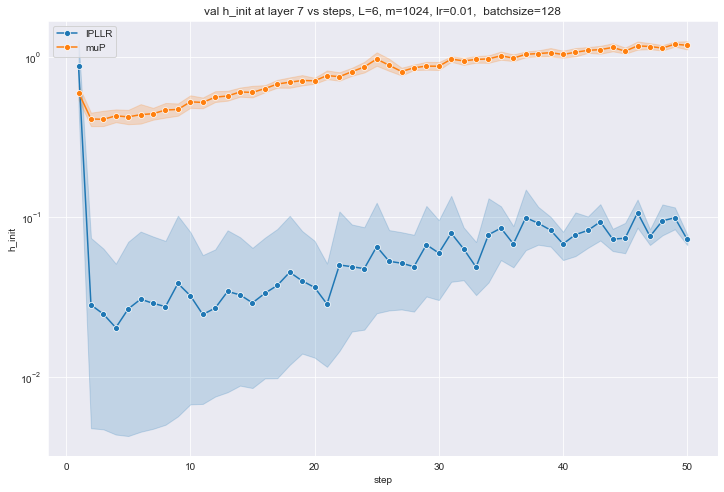

In [32]:
key = 'h_init'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

### Magnitude of the update at different layers.

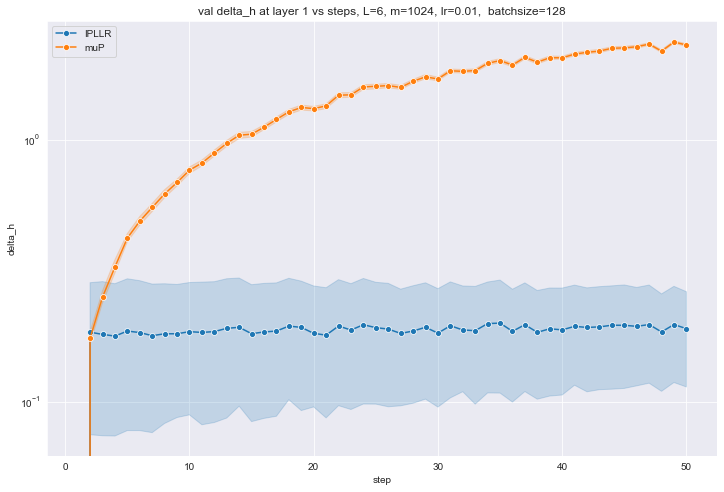

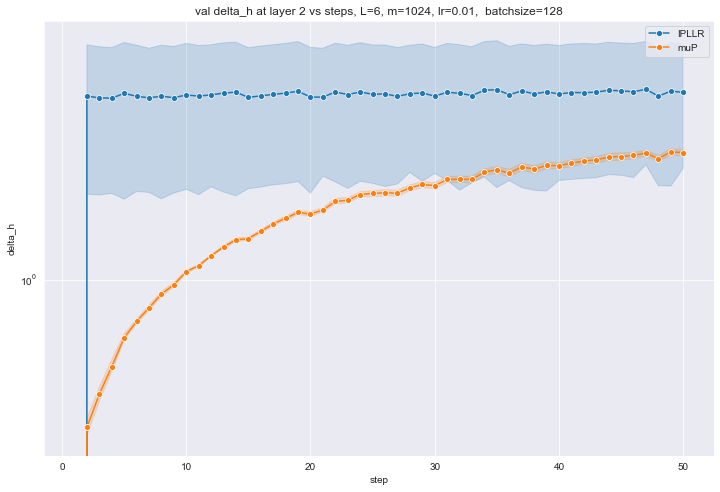

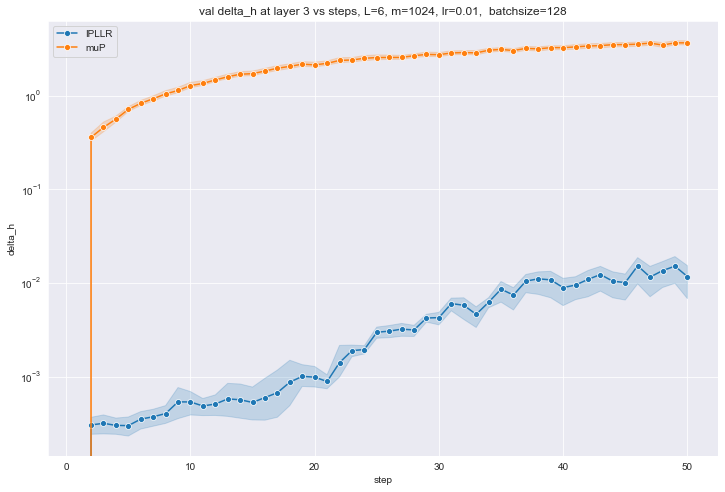

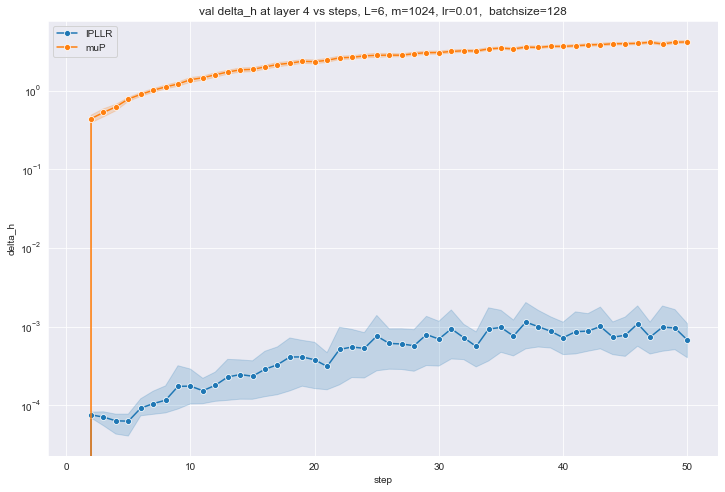

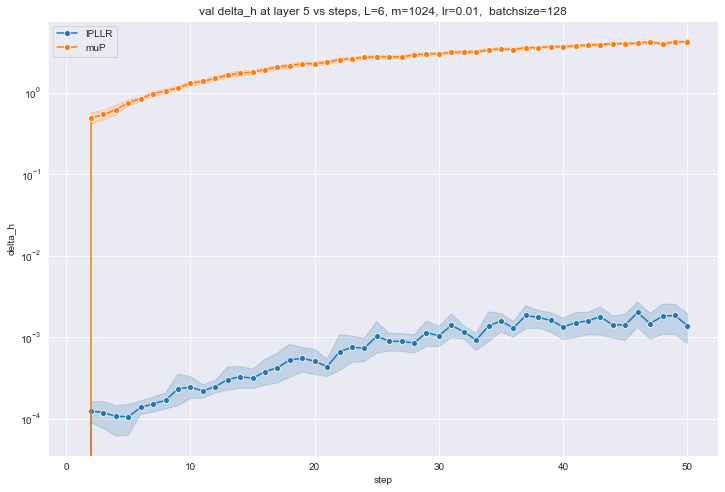

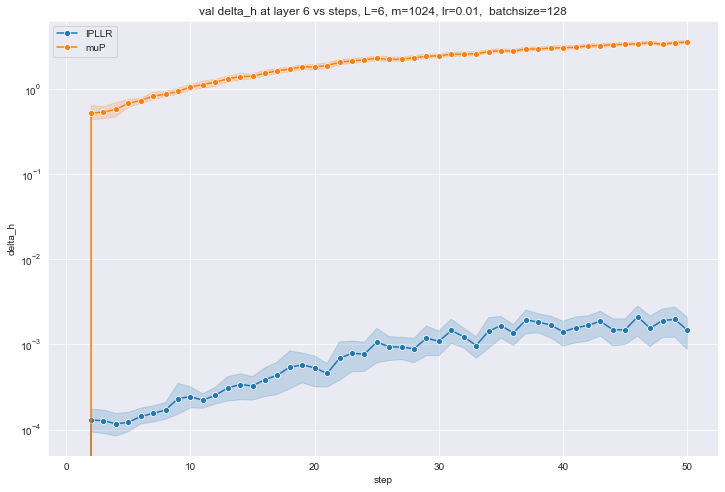

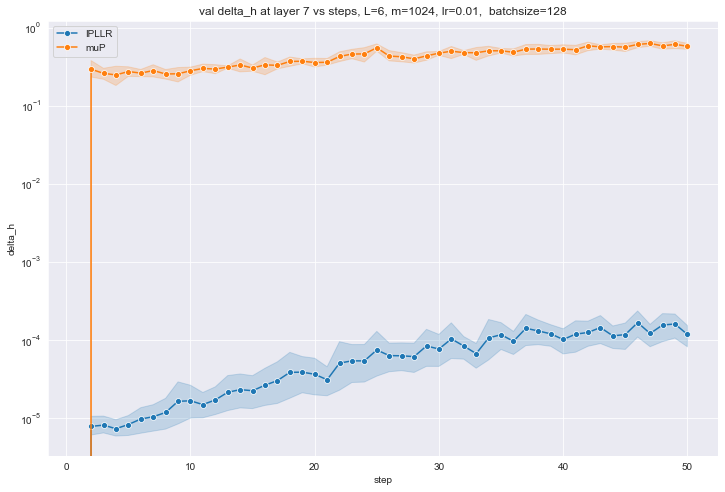

In [33]:
key = 'delta_h'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()